In [116]:
import open3d as o3d
import time
import skvideo.io 
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from plyfile import PlyData, PlyElement

import os
import subprocess

from pathlib import Path

from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch

torch.set_grad_enabled(False)

# Make Scikit-Video happy
np.float = np.float64
np.int = np.int_

# From
# https://medium.com/@nearlydaniel/assertion-of-arbitrary-array-shapes-in-python-3c96f6b7ccb4
from collections import defaultdict
def assert_shape(x, shape:list):
    """ ex: assert_shape(conv_input_array, [8, 3, None, None]) """
    assert len(x.shape) == len(shape), (x.shape, shape)
    for _a, _b in zip(x.shape, shape):
        if isinstance(_b, int):
            assert _a == _b, (x.shape, shape)

In [117]:
DATA_PATH = Path("data/cs_bldg")
every_frames = 100
end_frame = 100000

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [119]:
def get_matches(image0, image1):
    image0 = torch.from_numpy(image0.transpose(2, 0, 1))
    image1 = torch.from_numpy(image1.transpose(2, 0, 1))

    feats0 = extractor.extract(image0.to(device))
    feats1 = extractor.extract(image1.to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats0, feats1, matches01 = [
        rbd(x) for x in [feats0, feats1, matches01]
    ]  # remove batch dimension

    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]

    return m_kpts0, m_kpts1

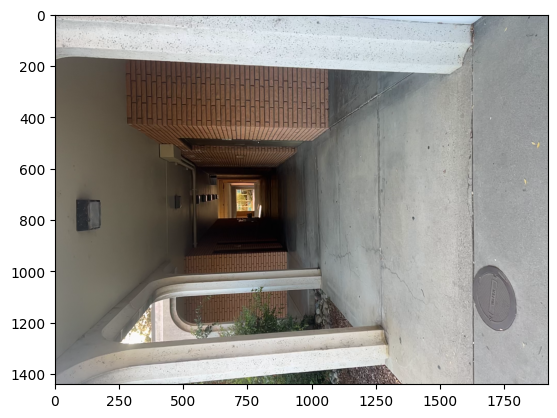

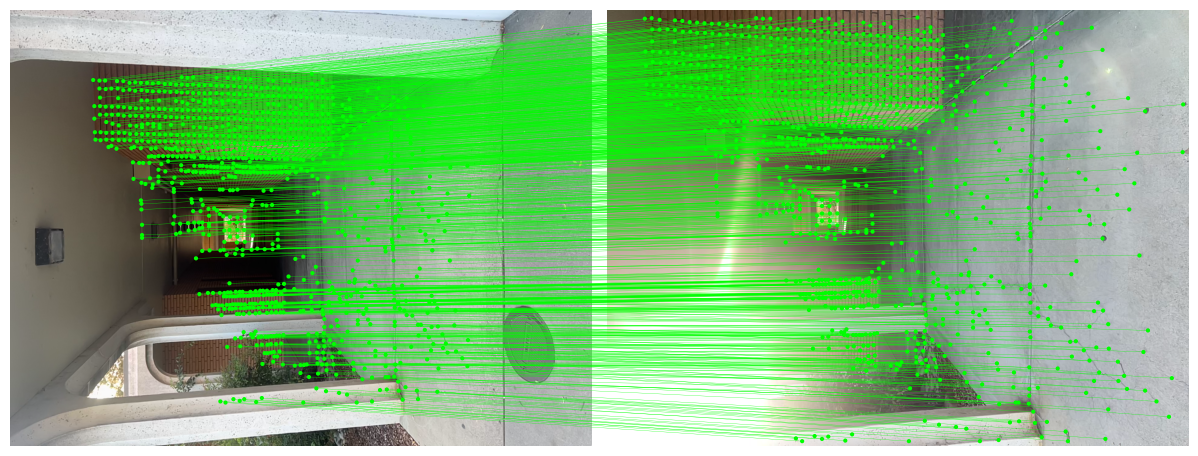

In [120]:
def extract_frames(video_path, frame_dir):
    os.makedirs(frame_dir, exist_ok=True)
    
    subprocess.run([
        'ffmpeg', '-i', video_path, '-vsync', 'vfr', '-q:v', '1', '-start_number', '0',
        os.path.join(frame_dir, '%06d.png')
    ])

if not os.path.exists(DATA_PATH.joinpath("frames")):
    extract_frames(DATA_PATH.joinpath("rgb.mp4"), DATA_PATH.joinpath("frames"))

video_image_paths = sorted(list(DATA_PATH.glob("frames/*.png")))[:end_frame:every_frames]

rgb_images = [skimage.io.imread(path).astype('float32') / 255.0 for path in video_image_paths]

plt.imshow(rgb_images[0])

confidence_images = [skimage.io.imread(path) for path in sorted(list(DATA_PATH.glob("confidence/*.png"))[:end_frame:every_frames])]
# confidence_image = skimage.transform.resize(confidence_image, rgb_image.shape[0:2], order=0)


# new_rgb_image = np.zeros((rgb_image.shape[0], rgb_image.shape[1], 3))

# new_rgb_image[..., 0] = (rgb_image == 0)
# new_rgb_image[..., 1] = (rgb_image == 1)
# new_rgb_image[..., 2] = (rgb_image == 2)

# rgb_image = new_rgb_image * 255


np.array_equal(rgb_images[0], rgb_images[1])

m_kpts0, m_kpts1 =  get_matches(rgb_images[0], rgb_images[1])


axes = viz2d.plot_images([rgb_images[0], rgb_images[1]])
viz2d.plot_matches(m_kpts0, m_kpts1, color="lime", lw=0.2)

In [121]:
calibration_matrix = np.genfromtxt(DATA_PATH.joinpath("camera_matrix.csv"), delimiter=',')
calibration_matrix

array([[1.4307429e+03, 0.0000000e+00, 9.6081350e+02],
       [0.0000000e+00, 1.4307429e+03, 7.2081390e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

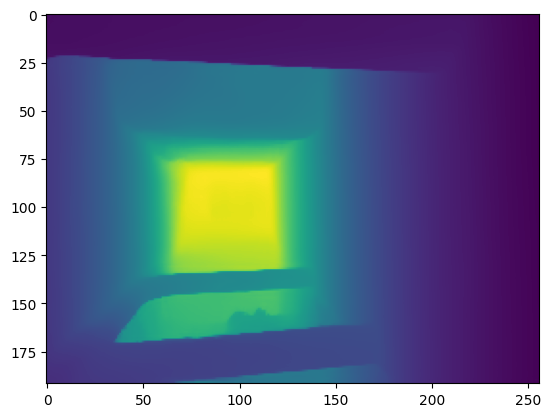

In [122]:
depth_image_paths = sorted(list(DATA_PATH.glob("depth/*.png")))[1:end_frame:every_frames]

depth_images = [skimage.io.imread(path) for path in depth_image_paths]

plt.imshow(depth_images[0])

In [123]:
def points_2d_to_3d(points_homogenous_2d: np.array, depths: np.array, calibration_matrix: np.array):

    assert_shape(points_homogenous_2d, (None, 3))

    point_num = len(points_homogenous_2d)

    assert_shape(depths, (point_num, 1))
    assert_shape(calibration_matrix, (3,3))

    # Ray from Point in Image:
    # Ideas from https://www.cs.cmu.edu/~16385/s17/Slides/11.1_Camera_matrix.pdf
    # And https://stackoverflow.com/questions/68249598/how-to-calculate-the-ray-of-a-camera-with-the-help-of-the-camera-matrix

    camera_matrix_inv = np.linalg.inv(calibration_matrix)

    directions = np.matmul(camera_matrix_inv, points_homogenous_2d.T).T
    directions = directions / np.linalg.norm(directions)
    point_cloud = directions * depths # Add Depth info!


    assert_shape(point_cloud, (None, 3))

    return point_cloud[:, 0:3]

def image_to_point_cloud(calibration_matrix: np.array, rgb_image: np.array, depth_map: np.array, confidence_image=None, min_confidence_level=2) -> np.array:
    assert_shape(calibration_matrix, (3,3))

    assert_shape(rgb_image, (None, None, 3))
    height = rgb_image.shape[0]
    width = rgb_image.shape[1]

    assert_shape(depth_map, (None, None))



    xv, yv = np.meshgrid(np.arange(width), np.arange(height))
    all_pixels = np.stack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()], axis=1)
    
    
    # Upscale depth to the same as our RGB image
    upscaled_depth_image = skimage.transform.resize(depth_map, rgb_image.shape[0:2], order=0).reshape(-1, 1)

    # Filter based on filter image
    if confidence_image is not None:
        assert_shape(confidence_image, (depth_map.shape[0], depth_map.shape[1]))

        # Rescale
        binary_filter_image = skimage.transform.resize(confidence_image, rgb_image.shape[0:2], order=0) >= min_confidence_level

        all_pixels = all_pixels[binary_filter_image.ravel()]
        upscaled_depth_image = upscaled_depth_image[binary_filter_image.ravel()]




    point_cloud = points_2d_to_3d(all_pixels, upscaled_depth_image, calibration_matrix)

    assert_shape(point_cloud, (None, 3))

    return point_cloud

In [124]:
def compute_euclidean_transform_ransac(image0, point_cloud0, image1, point_cloud1, matching_threshold=0.3, iterations=100)-> skimage.transform.EuclideanTransform:
    
    assert_shape(image0, (None, None, 3))
    
    image0_height = image0.shape[0]
    image0_width = image0.shape[1]
    assert_shape(point_cloud0, (image0_height * image0_width, 3))


    assert_shape(image1, (None, None, 3))

    image1_height = image1.shape[0]
    image1_width = image1.shape[1]

    assert_shape(point_cloud1, (image1_height * image1_width, 3))


    # Shape (None, 2), (None, 2)
    matched_keypoints0, matched_keypoints1 = get_matches(image0, image1)

    # Round to nearest pixel
    matched_keypoints0 = np.round(matched_keypoints0.numpy()).astype(int)
    matched_keypoints1 = np.round(matched_keypoints1.numpy()).astype(int)

    # Turn (x, y) from image coordinates into index into point cloud
    point_cloud0_indices = matched_keypoints0[:, 0] + matched_keypoints0[:, 1] * image0_width
    point_cloud1_indices = matched_keypoints1[:, 0] + matched_keypoints1[:, 1] * image1_width

    # Get the 3D points for the matched keypoints
    matched_point_cloud0 = point_cloud0[point_cloud0_indices]
    matched_point_cloud1 = point_cloud1[point_cloud1_indices]


    best_model = None
    best_inlier_count = 0

    for _ in range(iterations):

        # Get 3 random indices
        random_indices = np.random.choice(len(matched_point_cloud0), 3)

        model = skimage.transform.EuclideanTransform()
        model.estimate(matched_point_cloud0[random_indices], matched_point_cloud1[random_indices])

        transformed_points = model(matched_point_cloud0)

        # Get inliers under threshold
        error = np.sqrt(np.sum((transformed_points - matched_point_cloud1)**2, axis=1))

        inlier_count = np.count_nonzero(error < matching_threshold)

        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_model = model

    print(best_model, f"Inliers: {best_inlier_count}")
    
    return best_model, best_inlier_count


In [125]:
def add_point_cloud_to_viz(point_cloud, rgb_image, vis, confidence_image=None, min_confidence_level=2, accumualte_points=None, accumulate_colors=None):

    assert_shape(rgb_image, (None, None, 3))
    assert_shape(point_cloud, (None, 3))

    colors = rgb_image.reshape(-1,3)

    if confidence_image is not None:
        
        assert_shape(confidence_image, (None, None))

        binary_filter_image = skimage.transform.resize(confidence_image, rgb_image.shape[0:2], order=0) >= min_confidence_level
        colors = colors[binary_filter_image.ravel()]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud)
    pcd.colors = o3d.utility.Vector3dVector(colors)

    if accumualte_points is not None:
        accumualte_points.append(point_cloud)
        accumulate_colors.append(colors)

    vis.add_geometry(pcd)

In [126]:
def save_point_cloud_to_ply(filename, point_cloud, colors):
    vertices = [(point_cloud[i, 0], point_cloud[i, 1], point_cloud[i, 2],
             int(colors[i, 0] * 255), int(colors[i, 1] * 255), int(colors[i, 2] * 255))
            for i in range(point_cloud.shape[0])]
    ply_data = PlyElement.describe(
        np.array(vertices, dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]),
        'vertex')
    PlyData([ply_data]).write(filename)

In [127]:
model_to_0 = None


# create visualizer and window.
vis = o3d.visualization.Visualizer()
vis.create_window(height=480, width=640)

points = []
colors = []


last_point_cloud = image_to_point_cloud(calibration_matrix, rgb_images[0], depth_images[0])
last_rgb_image = rgb_images[0]

# Add first image to point cloud
add_point_cloud_to_viz(image_to_point_cloud(calibration_matrix, rgb_images[0], depth_images[0], confidence_image=confidence_images[0]), rgb_images[0], vis, confidence_images[0])


for idx in range(1, len(rgb_images)-1):
    point_cloud1 = image_to_point_cloud(calibration_matrix, rgb_images[idx], depth_images[idx])

    model, inliers = compute_euclidean_transform_ransac(rgb_images[idx], point_cloud1, last_rgb_image, last_point_cloud, matching_threshold=0.1, iterations=1000)

    if inliers < 100:
        print("Not enough inliers")
        continue

    last_point_cloud = point_cloud1
    last_rgb_image = rgb_images[idx]

    point_cloud1 = image_to_point_cloud(calibration_matrix, rgb_images[idx], depth_images[idx], confidence_images[idx])

    if model_to_0 is not None:
        # multiply the transformation matrix by the one to zero
        model_to_0 = model_to_0 + model
    else:
        model_to_0 = model

    point_cloud1 = model_to_0(point_cloud1)

    add_point_cloud_to_viz(point_cloud1, rgb_images[idx], vis, confidence_images[idx], accumualte_points=None, accumulate_colors=None)

    


# save_point_cloud_teo_ply("point_cloud.ply", np.concatenate(points), np.concatenate(colors))

# run non-blocking visualization. 
# To exit, press 'q' or click the 'x' of the window.
keep_running = True
while keep_running:
    keep_running = vis.poll_events()
    vis.update_renderer()

vis.destroy_window()

<EuclideanTransform(matrix=
    [[ 9.99802612e-01,  1.98544420e-02, -7.34020230e-04, -2.03560855e-02],
     [-1.98495032e-02,  9.99783664e-01,  6.21462195e-03,  1.34151363e-01],
     [ 8.57249287e-04, -6.19882532e-03,  9.99980420e-01,  4.94302859e-01],
     [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])> Inliers: 637
<EuclideanTransform(matrix=
    [[ 0.99937022,  0.010892  , -0.03377184, -0.01172169],
     [-0.01072831,  0.99992983,  0.00502451, -0.02513438],
     [ 0.03382419, -0.00465903,  0.99941694,  0.34804839],
     [ 0.        ,  0.        ,  0.        ,  1.        ]])> Inliers: 444
<EuclideanTransform(matrix=
    [[ 0.99963785, -0.02198577, -0.01551784, -0.11381949],
     [ 0.0217995 ,  0.99968947, -0.01207219, -0.13057686],
     [ 0.01577844,  0.01172954,  0.99980671,  0.45656787],
     [ 0.        ,  0.        ,  0.        ,  1.        ]])> Inliers: 630
<EuclideanTransform(matrix=
    [[-0.12403844,  0.88083266,  0.4568898 , -1.94178799],
     [ 0.937